### Comparison of optimizers for LASSO parameter range experiments

sklearn has 2 ways to fit logistic regression models with a LASSO penalty: [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) (using the liblinear optimizer; i.e. coordinate descent), and [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) (which uses stochastic gradient descent).

Here, we want to compare mutation prediction results between the two optimizers, across all the cancer genes in our driver gene set.

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
ll_base_results_dir = os.path.join(
    cfg.repo_root, '02_cancer_type_classification', 'results', 'lasso_range_lr_all_features'
)

# this doesn't have a sex covariate but it's probably close enough
sgd_base_results_dir = os.path.join(
    cfg.repo_root, '02_cancer_type_classification', 'results', 'lasso_range_valid'
)

training_dataset = 'all_other_cancers'
ll_results_dir = os.path.join(ll_base_results_dir, training_dataset)
sgd_results_dir = os.path.join(sgd_base_results_dir, training_dataset)

metric = 'aupr'
test_gene = 'TP53' # TODO: remove after testing

output_plots = False
output_plots_dir = None

### Get coefficient information for each lasso penalty

In [3]:
# these are generated from results files pretty slowly so it helps to cache them
ll_coefs_df_file = './ll_coefficients_df.tsv'

if os.path.exists(ll_coefs_df_file):
    print('exists')
    ll_nz_coefs_df = pd.read_csv(ll_coefs_df_file, sep='\t', index_col=0)
else:
    print('not exists')
    ll_nz_coefs_df = []
    # get coefficient info for training dataset specified above
    for coef_info in au.generate_nonzero_coefficients_lasso_range(ll_results_dir,
                                                                  gene=test_gene):
        (gene,
         cancer_type,
         seed,
         lasso_param,
         coefs_list) = coef_info
        for fold_no, coefs in enumerate(coefs_list):
            ll_nz_coefs_df.append(
                [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
            )
    ll_nz_coefs_df = pd.DataFrame(
        ll_nz_coefs_df,
        columns=['gene', 'cancer_type', 'lasso_param', 'seed', 'fold', 'nz_coefs']
    )
    ll_nz_coefs_df.lasso_param = ll_nz_coefs_df.lasso_param.astype(float)
    ll_nz_coefs_df.to_csv(ll_coefs_df_file, sep='\t')
                                                                  
ll_nz_coefs_df.head()

not exists


,gene,cancer_type,lasso_param,seed,fold,nz_coefs
0,TP53,READ,10.0,1,0,7851
1,TP53,READ,10.0,1,1,7711
2,TP53,READ,10.0,1,2,8009
3,TP53,READ,10.0,1,3,7716
4,TP53,GBM,1000.0,1,0,15297


In [4]:
# these are generated from results files pretty slowly so it helps to cache them
sgd_coefs_df_file = './sgd_coefficients_df.tsv'

if os.path.exists(sgd_coefs_df_file):
    print('exists')
    sgd_nz_coefs_df = pd.read_csv(sgd_coefs_df_file, sep='\t', index_col=0)
else:
    print('not exists')
    sgd_nz_coefs_df = []
    # get coefficient info for training dataset specified above
    for coef_info in au.generate_nonzero_coefficients_lasso_range(sgd_results_dir,
                                                                  gene=test_gene):
        (gene,
         cancer_type,
         seed,
         lasso_param,
         coefs_list) = coef_info
        for fold_no, coefs in enumerate(coefs_list):
            sgd_nz_coefs_df.append(
                [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
            )
    sgd_nz_coefs_df = pd.DataFrame(
        sgd_nz_coefs_df,
        columns=['gene', 'cancer_type', 'lasso_param', 'seed', 'fold', 'nz_coefs']
    )
    sgd_nz_coefs_df.lasso_param = sgd_nz_coefs_df.lasso_param.astype(float)
    sgd_nz_coefs_df.to_csv(sgd_coefs_df_file, sep='\t')
                                                                  
sgd_nz_coefs_df.head()

not exists


,gene,cancer_type,lasso_param,seed,fold,nz_coefs
0,TP53,UCEC,0.00025,42,0,6882
1,TP53,UCEC,0.00025,42,1,6827
2,TP53,UCEC,0.00025,42,2,6923
3,TP53,UCEC,0.00025,42,3,6898
4,TP53,LUAD,0.00050,1,0,6143


### Get performance information for each lasso penalty

In [5]:
# load performance information
ll_perf_df_file = './ll_perf_df.tsv'

if os.path.exists(ll_perf_df_file):
    print('exists')
    ll_perf_df = pd.read_csv(ll_perf_df_file, sep='\t', index_col=0)
else:
    print('not exists')
    ll_perf_df = au.load_prediction_results_lasso_range(ll_results_dir,
                                                        'liblinear',
                                                        gene=test_gene)
    ll_perf_df.rename(columns={'experiment': 'optimizer'}, inplace=True)
    ll_perf_df.lasso_param = ll_perf_df.lasso_param.astype(float)
    ll_perf_df.to_csv(ll_perf_df_file, sep='\t')

ll_perf_df.head()

not exists


,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,optimizer,lasso_param
0,1.00000,1.00000,TP53,PRAD,signal,1,train,0,liblinear,1500.0
1,0.72444,0.23601,TP53,PRAD,signal,1,test,0,liblinear,1500.0
2,0.90611,0.89081,TP53,PRAD,signal,1,cv,0,liblinear,1500.0
3,1.00000,1.00000,TP53,PRAD,signal,1,train,1,liblinear,1500.0
4,0.73958,0.37246,TP53,PRAD,signal,1,test,1,liblinear,1500.0


In [6]:
# add nonzero coefficient count
ll_plot_df = (
    ll_perf_df[(ll_perf_df.signal == 'signal')]
      .merge(ll_nz_coefs_df, left_on=['holdout_cancer_type', 'lasso_param', 'seed', 'fold'],
             right_on=['cancer_type', 'lasso_param', 'seed', 'fold'])
      .drop(columns=['cancer_type', 'gene_y'])
      .rename(columns={'gene_x': 'gene'})
      .sort_values(by=['holdout_cancer_type', 'lasso_param'])
      .reset_index(drop=True)
)
ll_plot_df.lasso_param = ll_plot_df.lasso_param.astype(float)

print(ll_plot_df.shape)
ll_plot_df.head()

(7680, 11)


,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,optimizer,lasso_param,nz_coefs
0,0.5,0.47534,TP53,BLCA,signal,1,train,0,liblinear,0.001,0
1,0.5,0.54082,TP53,BLCA,signal,1,test,0,liblinear,0.001,0
2,0.5,0.47334,TP53,BLCA,signal,1,cv,0,liblinear,0.001,0
3,0.5,0.47109,TP53,BLCA,signal,1,train,1,liblinear,0.001,0
4,0.5,0.47959,TP53,BLCA,signal,1,test,1,liblinear,0.001,0


In [7]:
# load performance information
sgd_perf_df_file = './sgd_perf_df.tsv'

if os.path.exists(sgd_perf_df_file):
    print('exists')
    sgd_perf_df = pd.read_csv(sgd_perf_df_file, sep='\t', index_col=0)
else:
    print('not exists')
    sgd_perf_df = au.load_prediction_results_lasso_range(sgd_results_dir,
                                                        'sgd',
                                                        gene=test_gene)
    sgd_perf_df.rename(columns={'experiment': 'optimizer'}, inplace=True)
    sgd_perf_df.lasso_param = sgd_perf_df.lasso_param.astype(float)
    sgd_perf_df.to_csv(sgd_perf_df_file, sep='\t')

sgd_perf_df.head()

not exists


,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,optimizer,lasso_param
0,0.661710,0.63834,TP53,OV,signal,42,train,0,sgd,0.1
1,0.089431,0.84457,TP53,OV,signal,42,test,0,sgd,0.1
2,0.668130,0.60945,TP53,OV,signal,42,cv,0,sgd,0.1
3,0.685860,0.62514,TP53,OV,signal,42,train,1,sgd,0.1
4,0.666670,0.97639,TP53,OV,signal,42,test,1,sgd,0.1


In [8]:
# add nonzero coefficient count
sgd_plot_df = (
    sgd_perf_df[(sgd_perf_df.signal == 'signal')]
      .merge(sgd_nz_coefs_df, left_on=['holdout_cancer_type', 'lasso_param', 'seed', 'fold'],
             right_on=['cancer_type', 'lasso_param', 'seed', 'fold'])
      .drop(columns=['cancer_type', 'gene_y'])
      .rename(columns={'gene_x': 'gene'})
      .sort_values(by=['holdout_cancer_type', 'lasso_param'])
      .reset_index(drop=True)
)
sgd_plot_df.lasso_param = sgd_plot_df.lasso_param.astype(float)

print(sgd_plot_df.shape)
sgd_plot_df.head()

(4800, 11)


,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,optimizer,lasso_param,nz_coefs
0,0.99994,0.99993,TP53,BLCA,signal,1,train,0,sgd,0.0001,7408
1,0.86038,0.89194,TP53,BLCA,signal,1,test,0,sgd,0.0001,7408
2,0.89676,0.87061,TP53,BLCA,signal,1,cv,0,sgd,0.0001,7408
3,0.99978,0.99982,TP53,BLCA,signal,1,train,1,sgd,0.0001,7397
4,0.86191,0.85000,TP53,BLCA,signal,1,test,1,sgd,0.0001,7397


In [9]:
all_perf_df = pd.concat((ll_plot_df, sgd_plot_df)).reset_index(drop=True)

print(all_perf_df.shape)
print(all_perf_df.optimizer.unique())
all_perf_df.head()

(12480, 11)
['liblinear' 'sgd']


,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,optimizer,lasso_param,nz_coefs
0,0.5,0.47534,TP53,BLCA,signal,1,train,0,liblinear,0.001,0
1,0.5,0.54082,TP53,BLCA,signal,1,test,0,liblinear,0.001,0
2,0.5,0.47334,TP53,BLCA,signal,1,cv,0,liblinear,0.001,0
3,0.5,0.47109,TP53,BLCA,signal,1,train,1,liblinear,0.001,0
4,0.5,0.47959,TP53,BLCA,signal,1,test,1,liblinear,0.001,0


### Select best lasso parameter for each optimizer

We'll do this for both CV (validation) datasets and test (holdout cancer type) datasets.

In [10]:
# get mean AUPR values across folds/seeds
ll_mean_aupr_df = (
    all_perf_df[(all_perf_df.data_type == 'cv') &
                (all_perf_df.optimizer == 'liblinear')]
      .drop(columns=['data_type', 'optimizer'])
      .groupby(['gene', 'holdout_cancer_type', 'lasso_param'])
      .agg(np.mean)
      .reset_index()
      .drop(columns=['seed', 'fold', 'auroc', 'nz_coefs'])
)

# get best LASSO parameter by mean AUPR, across all the ones we tried for this optimizer
ll_max_lasso_ix = (ll_mean_aupr_df
      .groupby(['gene', 'holdout_cancer_type'])
      .aupr.idxmax()
)
ll_max_lasso_param_df = ll_mean_aupr_df.loc[ll_max_lasso_ix, :]

print(ll_max_lasso_param_df.shape)
ll_max_lasso_param_df.head(8)

(20, 4)


,gene,holdout_cancer_type,lasso_param,aupr
3,TP53,BLCA,0.05,0.904764
19,TP53,BRCA,0.05,0.896253
35,TP53,CESC,0.05,0.899580
51,TP53,COAD,0.05,0.900161
67,TP53,ESCA,0.05,0.900505
83,TP53,GBM,0.05,0.901246
99,TP53,HNSC,0.05,0.900741
115,TP53,KICH,0.05,0.899381


In [11]:
# get mean AUPR values across folds/seeds
sgd_mean_aupr_df = (
    all_perf_df[(all_perf_df.data_type == 'cv') &
                (all_perf_df.optimizer == 'sgd')]
      .drop(columns=['data_type', 'optimizer'])
      .groupby(['gene', 'holdout_cancer_type', 'lasso_param'])
      .agg(np.mean)
      .reset_index()
      .drop(columns=['seed', 'fold', 'auroc', 'nz_coefs'])
)

# get best LASSO parameter by mean AUPR, across all the ones we tried for this optimizer
sgd_max_lasso_ix = (sgd_mean_aupr_df
      .groupby(['gene', 'holdout_cancer_type'])
      .aupr.idxmax()
)
sgd_max_lasso_param_df = sgd_mean_aupr_df.loc[sgd_max_lasso_ix, :]

print(sgd_max_lasso_param_df.shape)
sgd_max_lasso_param_df.head(8)

(20, 4)


,gene,holdout_cancer_type,lasso_param,aupr
0,TP53,BLCA,0.0001,0.858590
10,TP53,BRCA,0.0001,0.862163
20,TP53,CESC,0.0001,0.859352
30,TP53,COAD,0.0001,0.850958
44,TP53,ESCA,0.0025,0.848063
50,TP53,GBM,0.0001,0.857474
60,TP53,HNSC,0.0001,0.854430
70,TP53,KICH,0.0001,0.859051


In [12]:
optimizer_diff_df = (ll_max_lasso_param_df
    .merge(sgd_max_lasso_param_df,
           left_on=['gene', 'holdout_cancer_type'],
           right_on=['gene', 'holdout_cancer_type'])
    .rename({'lasso_param_x': 'lasso_param_ll',
             'lasso_param_y': 'lasso_param_sgd'})
)
optimizer_diff_df['ll_sgd_diff'] = (
    optimizer_diff_df['aupr_x'] - optimizer_diff_df['aupr_y']
)

optimizer_diff_df.head()

,gene,holdout_cancer_type,lasso_param_x,aupr_x,lasso_param_y,aupr_y,ll_sgd_diff
0,TP53,BLCA,0.05,0.904764,0.0001,0.858590,0.046174
1,TP53,BRCA,0.05,0.896253,0.0001,0.862163,0.034090
2,TP53,CESC,0.05,0.899580,0.0001,0.859352,0.040228
3,TP53,COAD,0.05,0.900161,0.0001,0.850958,0.049204
4,TP53,ESCA,0.05,0.900505,0.0025,0.848063,0.052442


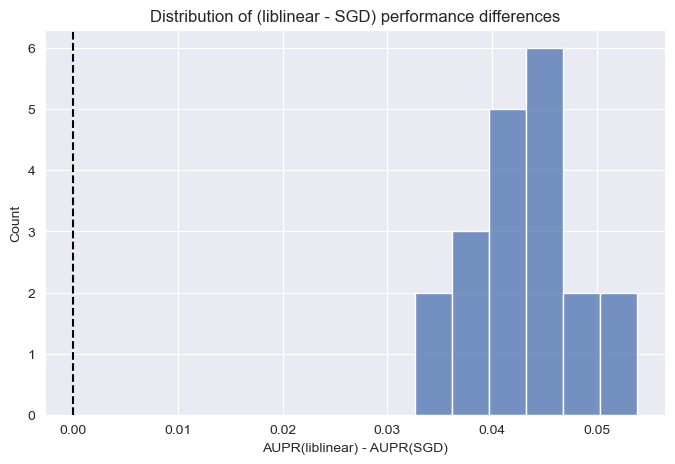

In [13]:
sns.set({'figure.figsize': (8, 5)})

sns.histplot(optimizer_diff_df.ll_sgd_diff)
plt.title('Distribution of (liblinear - SGD) performance differences')
plt.xlabel('AUPR(liblinear) - AUPR(SGD)')
plt.gca().axvline(x=0, color='black', linestyle='--')